In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, SMOTENC
from dython.nominal import associations
from dython.nominal import identify_nominal_columns

from sklearn.metrics import roc_auc_score,recall_score,f1_score, roc_curve, accuracy_score, auc, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Prepare dataset

In [2]:
# read dataset
df = pd.read_csv('diabetes_data.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


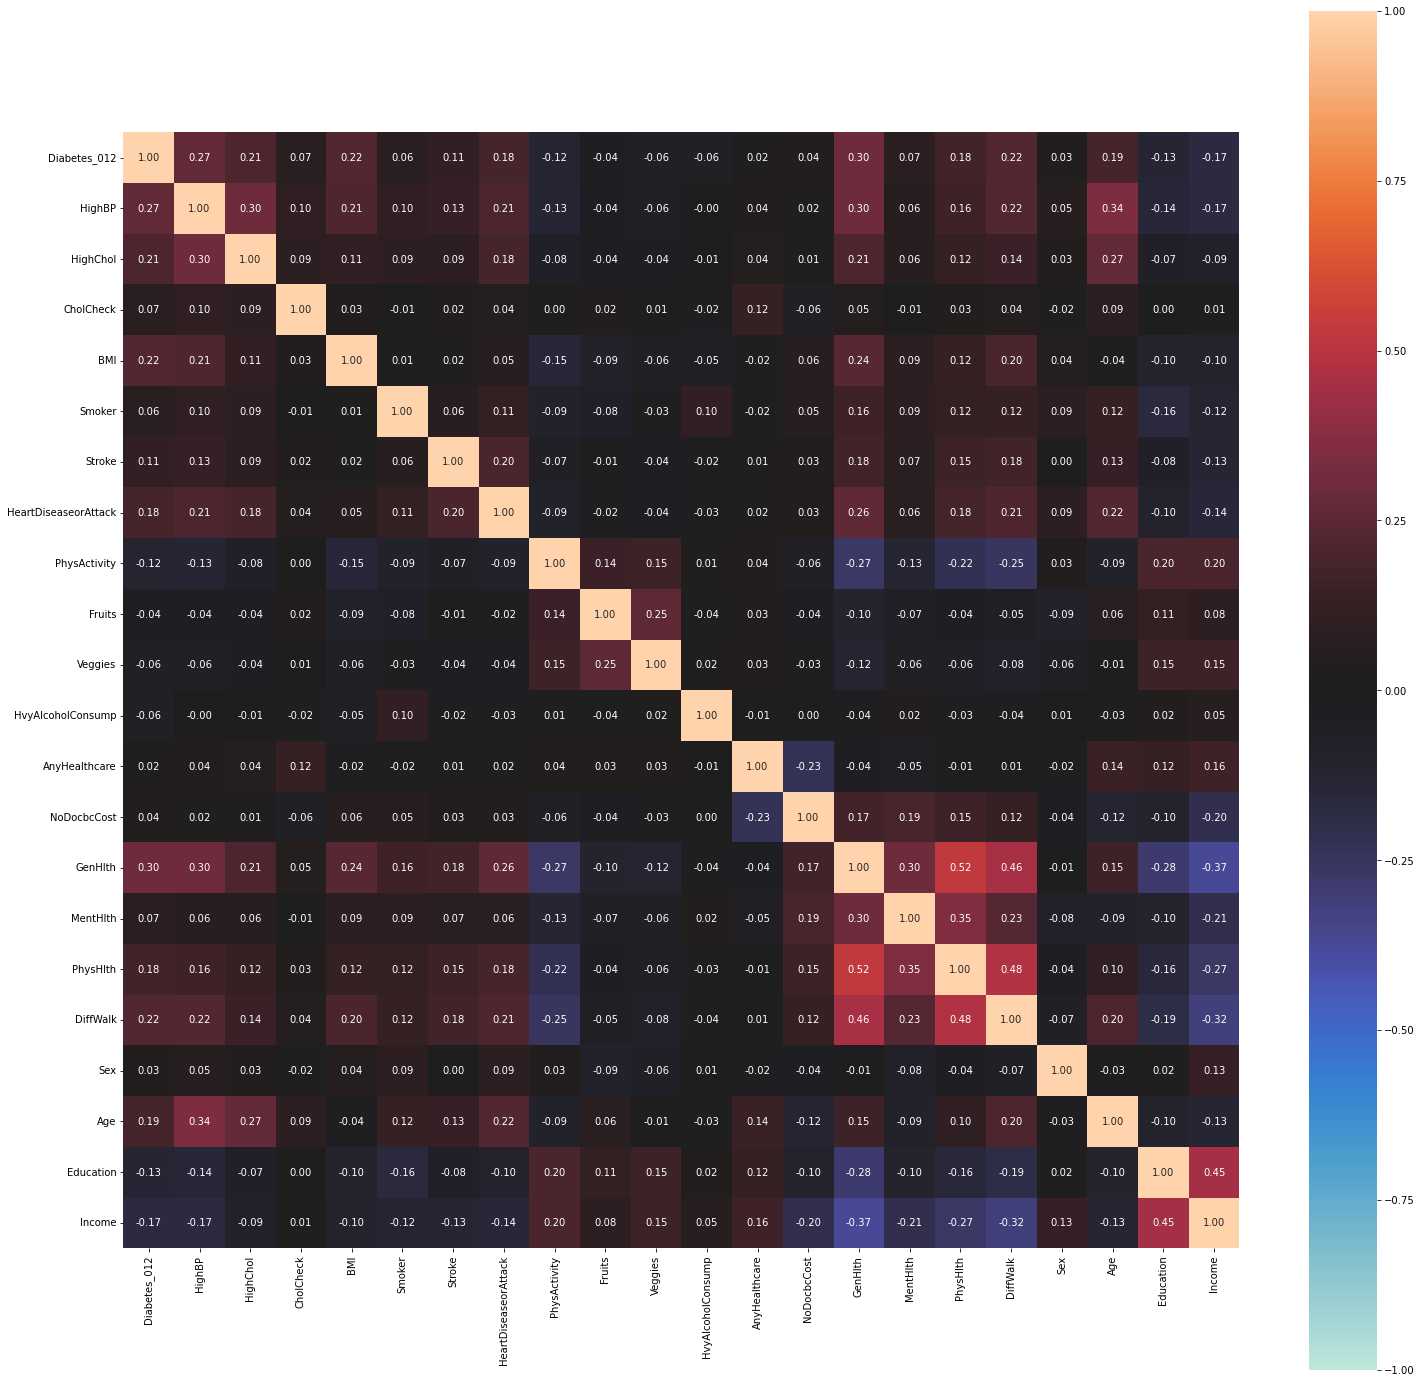

In [3]:
# check correlation
complete_correlation= associations(df, figsize=(25,25))
df_complete_corr = complete_correlation['corr']

In [4]:
# Proceed data
cat_feat = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
           'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 
           'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
num_feat = ['BMI','MentHlth', 'PhysHlth']

target = ['Diabetes_012']
# We tried to use one-hot encoding to transfer 'MentHlth', 'PhysHlth' into categorical feature,
# but we found out that it lower our model's efficiency without improving performance.
#enc1 = OneHotEncoder(handle_unknown='ignore')
#X1 = df[['MentHlth']]
#df['MentHlth_OH'] = list(enc1.fit_transform(X1).toarray())
#enc2 = OneHotEncoder(handle_unknown='ignore')
#X2 = df[['PhysHlth']]
#df['PhysHlth_OH'] = list(enc2.fit_transform(X2).toarray())

# make categorical data first and bmi last
df2 = pd.DataFrame()
df2[cat_feat]=df[cat_feat] 
df2[num_feat]=df[num_feat]
df2[target] = df[target]

for cat in cat_feat+target+num_feat:
    df2[cat] = df2[cat].astype('int')

df2.head()

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,DiffWalk,Sex,Age,Education,Income,BMI,MentHlth,PhysHlth,Diabetes_012
0,1,1,1,1,0,0,0,0,1,0,1,0,5,1,0,9,4,3,40,18,15,0
1,0,0,0,1,0,0,1,0,0,0,0,1,3,0,0,7,6,1,25,0,0,0
2,1,1,1,0,0,0,0,1,0,0,1,1,5,1,0,9,4,8,28,30,30,0
3,1,0,1,0,0,0,1,1,1,0,1,0,2,0,0,11,3,6,27,0,0,0
4,1,1,1,0,0,0,1,1,1,0,1,0,2,0,0,11,5,4,24,3,0,0


In [5]:
# add conditions
col_name = df_complete_corr[abs(df_complete_corr['Diabetes_012'])>=0.05].index
df3 = df2[col_name]
df3 = df3[df3['Diabetes_012'] != 1] #remove case 1
df3['Diabetes_012'] = df3['Diabetes_012'].map({2:1, 0:0})
df3.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,1,0,5,18,15,1,9,4,3
1,0,0,0,0,25,1,0,0,1,0,0,3,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,0,0,5,30,30,1,9,4,8
3,0,1,0,1,27,0,0,0,1,1,0,2,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,0,2,3,0,0,11,5,4


In [6]:
X = df3[df3.columns[1:]]
y = df3[target]

scaler=StandardScaler()
normalized_x=scaler.fit_transform(X.values)
X_train,X_test,y_train,y_test=train_test_split(normalized_x,y,test_size=0.3,random_state=6,stratify=y)

In [7]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_train2, y_train2 = rus.fit_resample(X_train, y_train)

In [10]:
#
models_dic = {'GaussianNB_best': GaussianNB(),
              'RandomForest_best': RandomForestClassifier(bootstrap = False,
                                                         class_weight = 'balanced', criterion='entropy',
                                                         max_depth = 10, max_features = 'sqrt',
                                                          n_estimators= 70),
              'DecisionTree_best':DecisionTreeClassifier(class_weight= 'balanced', criterion =  'gini',
                                                          max_depth = 10, max_features = 'auto'),
              'Logistic_best': LogisticRegression(n_jobs=-1),
              'LDA_best': LDA(n_components=1, shrinkage=1.0, solver='lsqr', tol=1.0),
              'QDA_best':QDA(),
              'KNN_best':KNeighborsClassifier(n_neighbors=39,
                               weights='uniform', # 'use uniform or distance'
                                algorithm='auto',
                                leaf_size=30,
                                p=2, # Euclidean distance
                                metric='minkowski',
                                metric_params=None,
                                n_jobs=None),
              'SVC':SVC(probability=True)
             }
models_dic          

{'GaussianNB_best': GaussianNB(),
 'RandomForest_best': RandomForestClassifier(bootstrap=False, class_weight='balanced',
                        criterion='entropy', max_depth=10, max_features='sqrt',
                        n_estimators=70),
 'DecisionTree_best': DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                        max_features='auto'),
 'Logistic_best': LogisticRegression(n_jobs=-1),
 'LDA_best': LinearDiscriminantAnalysis(n_components=1, shrinkage=1.0, solver='lsqr',
                            tol=1.0),
 'QDA_best': QuadraticDiscriminantAnalysis(),
 'KNN_best': KNeighborsClassifier(n_neighbors=39),
 'SVC': SVC(probability=True)}

In [11]:
import time
def evaluate_performance(model_dict, x, y, t):
    out = {"threshold": t}
    print('Start evaluating...')
    predict_time = []
    for model_name, model in model_dict.items():
        print(model_name)
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
        predict_start = time.time()
        metrics = ["acc", "precision", "recall", "f1", "auc"]
        probs = model.predict_proba(x)[:,1]
        #y_pred = probs>= t
        y_pred =  model.predict(x)
        predict_end = time.time()
        predict_time.append(predict_end - predict_start)
        y_true = y
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, probs)
        metrics_dict = dict(zip(metrics,np.array([acc,precision,recall,f1,auc])))
        out[model_name] = metrics_dict
    return out, predict_time

def roc_cal(y_true, probas):
    fpr, tpr, theshold = roc_curve(y_true, probas)
    return fpr, tpr

def plot_roc(models_dict, X_test_t, y_test, name):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,6))
    plt.title('Receiver Operating Characteristic')

    for model_name, model in models_dict.items():
        
        probs = model.predict_proba(X_test)[:,1]
        fpr, tpr = roc_cal(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,label = '{} AUC = {:.2f}'.format(model_name, roc_auc))

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig("{}".format(name))
    plt.show()##added by Ziyi
    plt.close()

Start fitting
GaussianNB_best
Current Time = 22:40:20
RandomForest_best
Current Time = 22:40:20
DecisionTree_best
Current Time = 22:40:22
Logistic_best
Current Time = 22:40:22
LDA_best
Current Time = 22:40:23
QDA_best
Current Time = 22:40:23
KNN_best
Current Time = 22:40:23
SVC
Current Time = 22:40:23
Start evaluating...
GaussianNB_best
Current Time = 22:51:38
RandomForest_best
Current Time = 22:51:38
DecisionTree_best
Current Time = 22:51:39
Logistic_best
Current Time = 22:51:39
LDA_best
Current Time = 22:51:39
QDA_best
Current Time = 22:51:39
KNN_best
Current Time = 22:51:39
SVC
Current Time = 22:53:17


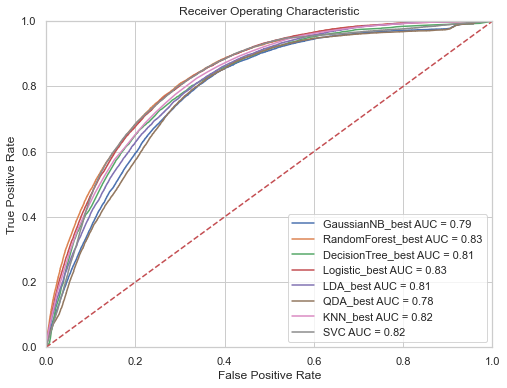

CPU times: user 24min 7s, sys: 3min 19s, total: 27min 27s
Wall time: 23min 17s


In [12]:
%%time
import warnings
import time
warnings.filterwarnings('ignore')


start = time.time()

sampling_time = time.time()

train_records = {}
record_df = pd.DataFrame()
print('Start fitting')
for model_name, model in models_dic.items():
    print(model_name)
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    train_records[model_name] = 0
    model_start = time.time()
    model.fit(X_train2, y_train2)
    model_end = time.time()
    train_records[model_name] = model_end - model_start

performance_df = pd.DataFrame()
performance_csv_name = "performance.csv"
record_name = "time_record.txt"

f = open(record_name,"w")
f.write(str(train_records))
f.close()

#for model_name, model in models_dic.items():
    #thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
    #for t in thresholds:
t = 'undefined'
performance_result,predict_time = evaluate_performance(models_dic, X_test, y_test, t) ####note: remove indent
    #performance_df = pd.concat([performance_df, pd.DataFrame.from_dict(performance_result)])
performance_df = pd.DataFrame.from_dict(performance_result).T.iloc[1:]

performance_df.to_csv(performance_csv_name)

figure_name = "AUC.png"
plot_roc(models_dic, X_test, y_test, figure_name)

In [25]:
performance_df['train_time'] = train_records.values()
performance_df['predict_time'] = predict_time
performance_df.index = list(performance_df.index[:-1]) + ['SVC_best']
performance_df.sort_values('recall', ascending=False)

,acc,precision,recall,f1,auc,train_time,predict_time
SVC_best,0.711397,0.304938,0.807808,0.442745,0.818521,674.642445,382.396422
KNN_best,0.703152,0.297165,0.799604,0.433298,0.818462,0.003280,97.878076
QDA_best,0.686783,0.283978,0.793286,0.418237,0.784127,0.036154,0.029693
RandomForest_best,0.72446,0.313757,0.793003,0.449619,0.831344,1.638924,0.793561
DecisionTree_best,0.706873,0.297014,0.779423,0.430122,0.807748,0.027780,0.012291
Logistic_best,0.736131,0.321346,0.772727,0.453923,0.827844,0.936724,0.004051
GaussianNB_best,0.724875,0.302289,0.717465,0.425361,0.788483,0.013829,0.022791
LDA_best,0.751482,0.323305,0.687099,0.43971,0.807442,0.076563,0.002063


In [26]:
performance_df.sort_values('recall', ascending=False).to_csv('best_model.csv')

# Without undersample

In [ ]:
%%time
import warnings
import time
warnings.filterwarnings('ignore')


start = time.time()

sampling_time = time.time()

train_records = {}
record_df = pd.DataFrame()
print('Start fitting')
for model_name, model in models_dic.items():
    print(model_name)
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    train_records[model_name] = 0
    model_start = time.time()
    model.fit(X_train, y_train)
    model_end = time.time()
    train_records[model_name] = model_end - model_start

performance_df = pd.DataFrame()
performance_csv_name = "performance.csv"
record_name = "time_record.txt"

f = open(record_name,"w")
f.write(str(train_records))
f.close()

#for model_name, model in models_dic.items():
    #thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
    #for t in thresholds:
t = 'undefined'
performance_result = evaluate_performance(models_dic, X_test, y_test, t) ####note: remove indent
    #performance_df = pd.concat([performance_df, pd.DataFrame.from_dict(performance_result)])
performance_df = pd.DataFrame.from_dict(performance_result).T.iloc[1:]

performance_df.to_csv(performance_csv_name)

figure_name = "AUC.png"
plot_roc(models_dic, X_test, y_test, figure_name)

In [ ]:
performance_df

# Hyperparameter tuning:
## Models:
    - GaussianNB
    - KNeighborsClassifier
    - Logistic Regression
    - LDA 
    - QDA
    - SVC
    - RandomForestClassifier
    - DecisionTreeClassifier

In [17]:
#example: GaussianNB
from sklearn.model_selection import GridSearchCV
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-20, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params_NB, 
                     cv=5,   # use any cross validation technique 
                     verbose=1, 
                     scoring='balanced_accuracy') 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 9.111627561154887e-05}

In [18]:
pd.DataFrame(gs_NB.cv_results_).sort_values('rank_test_score').to_csv('gaussian_tune.csv')

In [19]:
var_smoothing_lst = [9.111627561154887e-05, 0.1, 0.01,0.001,0.0001]
models_dic = {'GaussianNB': GaussianNB()}
for value in var_smoothing_lst:
    models_dic['GaussianNB_var_' + str(value)] = GaussianNB(var_smoothing = value)
    
models_dic

{'GaussianNB': GaussianNB(),
 'GaussianNB_var_9.111627561154887e-05': GaussianNB(var_smoothing=9.111627561154887e-05),
 'GaussianNB_var_0.1': GaussianNB(var_smoothing=0.1),
 'GaussianNB_var_0.01': GaussianNB(var_smoothing=0.01),
 'GaussianNB_var_0.001': GaussianNB(var_smoothing=0.001),
 'GaussianNB_var_0.0001': GaussianNB(var_smoothing=0.0001)}

In [18]:
def evaluate_performance(model_dict, x, y, t):
    out = {"threshold": t}
    print('Start evaluating...')
    for model_name, model in model_dict.items():
        print(model_name)
        metrics = ["acc", "precision", "recall", "f1", "auc"]
        probs = model.predict_proba(x)[:,1]
        #y_pred = probs>= t
        y_pred =  model.predict(x)
        y_true = y
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, probs)
        metrics_dict = dict(zip(metrics,np.array([acc,precision,recall,f1,auc])))
        out[model_name] = metrics_dict
    return out

def roc_cal(y_true, probas):
    fpr, tpr, theshold = roc_curve(y_true, probas)
    return fpr, tpr

def plot_roc(models_dict, X_test_t, y_test, name):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,6))
    plt.title('Receiver Operating Characteristic')

    for model_name, model in models_dict.items():
        
        probs = model.predict_proba(X_test)[:,1]
        fpr, tpr = roc_cal(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,label = '{} AUC = {:.2f}'.format(model_name, roc_auc))

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig("{}".format(name))
    plt.show()##added by Ziyi
    plt.close()

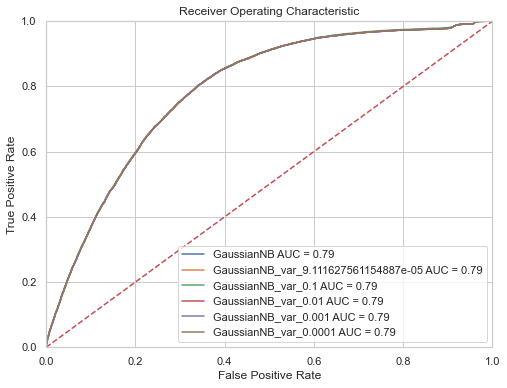

CPU times: user 882 ms, sys: 12.5 ms, total: 895 ms
Wall time: 895 ms


In [23]:
%%time
import warnings
import time
warnings.filterwarnings('ignore')


start = time.time()

sampling_time = time.time()

train_records = {}
record_df = pd.DataFrame()

for model_name, model in models_dic.items():
    train_records[model_name] = 0
    model_start = time.time()
    model.fit(X_train, y_train)
    model_end = time.time()
    train_records[model_name] = model_end - model_start

performance_df = pd.DataFrame()
performance_csv_name = "performance.csv"
record_name = "time_record.txt"

f = open(record_name,"w")
f.write(str(train_records))
f.close()

#for model_name, model in models_dic.items():
    #thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
    #for t in thresholds:
t = 'undefined'
performance_result = evaluate_performance(models_dic, X_test, y_test, t)
    #performance_df = pd.concat([performance_df, pd.DataFrame.from_dict(performance_result)])
performance_df = pd.DataFrame.from_dict(performance_result).T.iloc[1:]

performance_df.to_csv(performance_csv_name)

figure_name = "AUC.png"
plot_roc(models_dic, X_test, y_test, figure_name)

In [24]:
performance_df

,acc,precision,recall,f1,auc
GaussianNB,0.77544,0.333117,0.581101,0.423476,0.788795
GaussianNB_var_9.111627561154887e-05,0.77544,0.333117,0.581101,0.423476,0.788796
GaussianNB_var_0.1,0.784126,0.339809,0.552622,0.420841,0.789996
GaussianNB_var_0.01,0.776404,0.333896,0.578367,0.423374,0.78892
GaussianNB_var_0.001,0.77552,0.333153,0.580724,0.423405,0.788808
GaussianNB_var_0.0001,0.775427,0.333081,0.581007,0.423422,0.788796


# Conclusions:
 - GaussianNB: best params is the default setting as the default uses the smallest possible variance smoothing.

In [12]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_train2, y_train2 = rus.fit_resample(X_train, y_train)


# SVC

In [ ]:
%%time
model = SVC()
model.fit(X_train2,y_train2)
y_pred = model.predict(X_test)

In [17]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 0.5, 1],
              'gamma': ['scale', 'auto'],
              'kernel': ['linear','poly','rbf','sigmoid'],
            'class_weight':['balanced']}
 
clf = SVC(gamma='scale')


CPU times: user 547 µs, sys: 146 µs, total: 693 µs
Wall time: 590 µs


In [21]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
model = SVC()
gridSVC = GridSearchCV(estimator=model, 
                         param_grid=param_grid, 
                         cv=5,   # use any cross validation technique 
                         verbose=3, 
                         scoring='balanced_accuracy') 

gridSVC.fit(X_train2, y_train2)
# print best parameter after tuning
print(gridSVC.best_params_)
 
# print how our model looks after hyper-parameter tuning
#print(gridSVC.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear;, score=0.749 total time= 1.1min
[CV 2/5] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear;, score=0.748 total time= 1.0min
[CV 3/5] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear;, score=0.753 total time=  55.6s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear;, score=0.746 total time=  55.5s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear;, score=0.751 total time=  47.2s
[CV 1/5] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly;, score=0.744 total time= 1.2min
[CV 2/5] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly;, score=0.739 total time= 1.2min
[CV 3/5] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly;, score=0.742 total time= 1.1min
[CV 4/5] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly;, score=0.743 total time= 1.1min
[CV 5/5] END C=0.1,

[CV 2/5] END C=1, class_weight=balanced, gamma=scale, kernel=linear;, score=0.748 total time= 1.4min
[CV 3/5] END C=1, class_weight=balanced, gamma=scale, kernel=linear;, score=0.753 total time= 1.3min
[CV 4/5] END C=1, class_weight=balanced, gamma=scale, kernel=linear;, score=0.746 total time= 1.3min
[CV 5/5] END C=1, class_weight=balanced, gamma=scale, kernel=linear;, score=0.751 total time= 1.2min
[CV 1/5] END C=1, class_weight=balanced, gamma=scale, kernel=poly;, score=0.744 total time= 1.3min
[CV 2/5] END C=1, class_weight=balanced, gamma=scale, kernel=poly;, score=0.742 total time= 1.3min
[CV 3/5] END C=1, class_weight=balanced, gamma=scale, kernel=poly;, score=0.745 total time= 1.2min
[CV 4/5] END C=1, class_weight=balanced, gamma=scale, kernel=poly;, score=0.744 total time= 1.2min
[CV 5/5] END C=1, class_weight=balanced, gamma=scale, kernel=poly;, score=0.744 total time= 1.1min
[CV 1/5] END C=1, class_weight=balanced, gamma=scale, kernel=rbf;, score=0.748 total time= 2.0min
[CV

In [25]:
pd.DataFrame(gridSVC.cv_results_).sort_values('rank_test_score').to_csv('SVC_tune.csv')

In [32]:
svc_tune = pd.DataFrame(gridSVC.cv_results_).sort_values('rank_test_score')
#svc_tune['']
svc_tune['params'][3]

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'sigmoid'}

In [13]:
models_dic = {'SVC': SVC(probability=True),
             '0.5_scale_rbf': SVC(C = 0.5, class_weight='balanced', gamma='scale', kernel='rbf',probability=True),
              '0.1_scale_poly': SVC(C = 0.5, class_weight='balanced', gamma='auto', kernel='rbf',probability=True),
              '0.1_scale_rbf': SVC(C = 0.1, class_weight='balanced', gamma='scale', kernel='rbf',probability=True),
              '0.1_scale_sigmoid': SVC(C = 1, class_weight='balanced', gamma='auto', kernel='rbf',probability=True)
             }

In [14]:
def evaluate_performance(model_dict, x, y, t):
    out = {"threshold": t}
    print('start evaluate')
    for model_name, model in model_dict.items():
        print(model_name)
        metrics = ["acc", "precision", "recall", "f1", "auc"]
        probs = model.predict_proba(x)[:,1]
        #y_pred = probs>= t
        y_pred =  model.predict(x)
        y_true = y
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, probs)
        metrics_dict = dict(zip(metrics,np.array([acc,precision,recall,f1,auc])))
        out[model_name] = metrics_dict
    return out

def roc_cal(y_true, probas):
    fpr, tpr, theshold = roc_curve(y_true, probas)
    return fpr, tpr

def plot_roc(models_dict, X_test_t, y_test, name):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,6))
    plt.title('Receiver Operating Characteristic')

    for model_name, model in models_dict.items():
        
        probs = model.predict_proba(X_test)[:,1]
        fpr, tpr = roc_cal(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,label = '{} AUC = {:.2f}'.format(model_name, roc_auc))

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig("{}".format(name))
    plt.show()##added by Ziyi
    plt.close()

start fitting
SVC
0.5_scale_rbf
0.1_scale_poly
0.1_scale_rbf
0.1_scale_sigmoid
start evaluate
SVC
0.5_scale_rbf
0.1_scale_poly
0.1_scale_rbf
0.1_scale_sigmoid
start evaluate
SVC
0.5_scale_rbf
0.1_scale_poly
0.1_scale_rbf
0.1_scale_sigmoid
start evaluate
SVC
0.5_scale_rbf
0.1_scale_poly
0.1_scale_rbf
0.1_scale_sigmoid
start evaluate
SVC
0.5_scale_rbf
0.1_scale_poly
0.1_scale_rbf
0.1_scale_sigmoid
start evaluate
SVC
0.5_scale_rbf
0.1_scale_poly
0.1_scale_rbf
0.1_scale_sigmoid


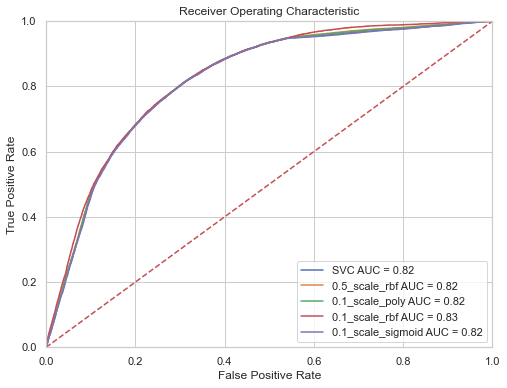

CPU times: user 3h 47min 40s, sys: 12.4 s, total: 3h 47min 52s
Wall time: 8h 28min 51s


In [15]:
%%time
import warnings
import time
warnings.filterwarnings('ignore')


start = time.time()

sampling_time = time.time()

train_records = {}
record_df = pd.DataFrame()
print('start fitting')
for model_name, model in models_dic.items():
    print(model_name)
    train_records[model_name] = 0
    model_start = time.time()
    model.fit(X_train2, y_train2)
    model_end = time.time()
    train_records[model_name] = model_end - model_start

performance_df = pd.DataFrame()
performance_csv_name = "performance.csv"
record_name = "time_record.txt"

f = open(record_name,"w")
f.write(str(train_records))
f.close()

#for model_name, model in models_dic.items():
    #thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
    #for t in thresholds:
t = 'undefined'
performance_result = evaluate_performance(models_dic, X_test, y_test, t) ####note: remove indent
    #performance_df = pd.concat([performance_df, pd.DataFrame.from_dict(performance_result)])
performance_df = pd.DataFrame.from_dict(performance_result).T.iloc[1:]

performance_df.to_csv(performance_csv_name)

figure_name = "AUC.png"
plot_roc(models_dic, X_test, y_test, figure_name)

In [16]:
performance_df

,acc,precision,recall,f1,auc
SVC,0.710968,0.304521,0.807337,0.442235,0.8181
0.5_scale_rbf,0.710553,0.304352,0.808469,0.442226,0.820767
0.1_scale_poly,0.709523,0.303467,0.808091,0.441235,0.819742
0.1_scale_rbf,0.707957,0.302924,0.812901,0.441372,0.825872
0.1_scale_sigmoid,0.710808,0.304377,0.807243,0.442069,0.816941


## Conclusion: Using default SVC is sufficient. Using a smaller C is too time-consuming while the performance does not have siginificant impove.